In [1]:
# TensorFlow and tf.keras

import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
# import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [2]:
grid = 32
# training data : 10,000 signal samples and 10,000 bkg samples
traindata_sig = np.load('data/jetImages_signal.npz')
traindata_bkg = np.load('data/jetImages_bkg.npz')
trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# testing data : 10,000 signal samples and 10,000 bkg samples
testdata_sig = np.load('data/jetImages_signal_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_test.npz')
testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)
trainradii = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
traintheta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
testradii = np.concatenate((testdata_sig['radiilab'], testdata_bkg['radiilab']), axis = 0)
test_theta = np.concatenate((testdata_sig['thetalab'], testdata_bkg['thetalab']), axis = 0)
trainz = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
testz = np.concatenate((testdata_sig['zlab'], testdata_bkg['zlab']), axis = 0)
n_train = len(trainlabels)
n_test = len(testlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
testimages = testimages.reshape(n_test, grid, grid, 1)

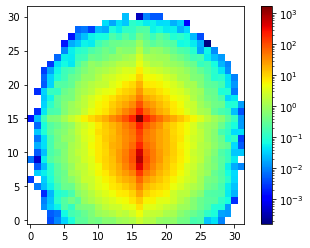

In [3]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

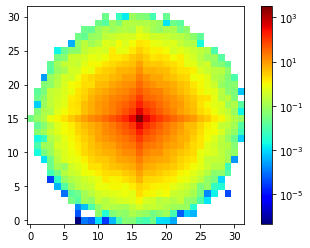

In [4]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [5]:
# !ls training
best_model = keras.models.load_model('model/CNN_cat_multi_input.h5')
best_model.summary()
results = best_model.evaluate([testimages, test_theta, testradii, testz], testlabels)
print(results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 22, 22, 32)   3904        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 20, 20, 32)   9248        conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 10, 10, 32)   0           conv2d_6[0][0]         

(20000, 1) (20000, 1)


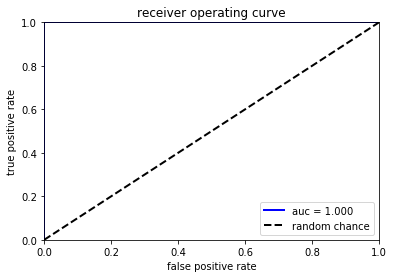

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [59]:
# Plot ROC
predict = best_model.predict([testimages, test_theta, testradii, testz])
print(testlabels.shape, predict.shape)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()
print(predict)

In [7]:
import innvestigate
import innvestigate.utils as iutils

In [8]:
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
print(trainradii[1].reshape(1,2))
# Applying the analyzer
# display = [trainimages[1].reshape(1,grid,grid,1), traintheta[1], trainradii[1].reshape(1,2), trainz[1]] #the reshape is this way is because the input is expected to be 4 dimensions
# analysis = lrp_analyzer.analyze(display)

# # Displaying one result
# plt.imshow(analysis[0].reshape(grid, grid), cmap='Reds', origin = 'low', interpolation='nearest')
# plt.colorbar()
# plt.clim(-0.6, 0.6)
# plt.show()

[[0.49883253 0.3112263 ]]


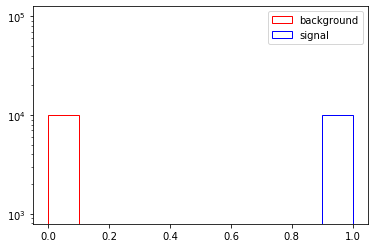

In [9]:
plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2):].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
toc = time.time()
def display(i):
    return [trainimages[i].reshape(1,grid,grid,1), traintheta[i], trainradii[i].reshape(1,2), trainz[i]]
analysis = [lrp_analyzer.analyze(display(i)) for i in range(len(trainimages))]

tic = time.time()

print('\n time = \n', tic-toc)


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

 time = 
 45.46532964706421


In [31]:
print(analysis[0][0][0][0])
print( "Relevance of theta:", analysis[0])
print("Relevance of radius 1:", analysis[1])
print("Relevance of radius 2:", analysis[0])
print("Relevance of z:",  analysis[0])
total_rel = np.ndarray(shape=(20000,))
for i in range(len(predict)):
    total_rel[i] = np.sum(analysis[i][0]) + np.sum(analysis[i][1]) + np.sum(analysis[i][2])
zeros = 0
for i in range(len(predict)):
    if total_rel[i] == 0.0:
        zeros+=1
print("total relevance: ", total_rel)

[[ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
Relevance of theta: [array([[[[ 0.],
         [ 0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[-0.],
         [-0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        ...,

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [-0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [-0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]]], dtype=float32), array([[0.2711235]], dtype=float32), array([[-0.005

In [12]:
print(analysis[0][0].shape)

sig_analysis_true = np.zeros_like(analysis[0][0])
bkg_analysis_true = np.zeros_like(analysis[0][0])
sig_analysis_pred = np.zeros_like(analysis[0][0])
bkg_analysis_pred = np.zeros_like(analysis[0][0])
sig_inefficiency = np.zeros_like(analysis[0][0])
bkg_inefficiency = np.zeros_like(analysis[0][0])

toc = time.time()

for i in range(len(trainimages)):
    if trainlabels[i] == 1:
        sig_analysis_true += analysis[i][0]  
        
    else:
        bkg_analysis_true += analysis[i][0]

sig_analysis_true /= len(trainimages)/2
bkg_analysis_true /= len(trainimages)/2
        
sig_anal_num = 0   
sig_inef_num = 0
bkg_anal_num = 0
bkg_inef_num = 0
weird = 0
sig_zlab = np.array([0.])
sig_thetalab = np.array([0.])
bkg_zlab = np.array([0.])
bkg_thetalab = np.array([0.])

sig_ineff_zlab = np.array([0.])
sig_ineff_thetalab = np.array([0.])
bkg_ineff_zlab = np.array([0.])
bkg_ineff_thetalab = np.array([0.])

for i in range(len(trainimages)):
    if i < int(len(predict)/2) and predict[i] > 0.50:
        sig_analysis_pred += analysis[i][0]
        sig_anal_num += 1
        sig_zlab = np.append(sig_zlab, trainz[i])
        sig_thetalab = np.append(sig_thetalab, traintheta[i])
    elif i < int(len(predict)/2) and predict[i] < 0.50:
        sig_inefficiency += analysis[i][0]
        sig_inef_num += 1
        sig_ineff_zlab = np.append(sig_ineff_zlab, train_zlabels[i])
        sig_ineff_thetalab = np.append(sig_ineff_thetalab, traintheta[i])
    elif i >= int(len(predict)/2) and predict[i] < 0.50:
        bkg_analysis_pred += analysis[i][0]
        bkg_anal_num += 1
        bkg_zlab = np.append(bkg_zlab, trainz[i])
        bkg_thetalab = np.append(bkg_thetalab, traintheta[i])
    elif i >= int(len(predict)/2) and predict[i] > 0.50:
        bkg_inefficiency += analysis[i][0]
        bkg_inef_num += 1
        bkg_ineff_zlab = np.append(bkg_ineff_zlab, trainz[i])
        bkg_ineff_thetalab = np.append(bkg_ineff_thetalab, traintheta[i])
        
#normalizing relevance scores
sig_analysis_pred /= sig_anal_num
sig_inefficiency /= sig_inef_num
bkg_analysis_pred /= bkg_anal_num
bkg_inefficiency /= bkg_inef_num

tic = time.time()
print('signal inefficiency = ', sig_inef_num, '\nbackground inefficiency = ', bkg_inef_num)
print('\ntime =\n', tic-toc)
print('signal efficiency = ', sig_anal_num, '\nbackground efficiency = ', bkg_anal_num)

(1, 32, 32, 1)
signal inefficiency =  0 
background inefficiency =  0

time =
 0.6379239559173584
signal efficiency =  10000 
background efficiency =  10000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


In [54]:
print("Relevance of 1st image:", np.sum(analysis[0][0]))
print( "Relevance of 1st theta:", analysis[0][1][0][0])
print("Relevance of 1st radius 1:", analysis[0][2][0][0])
print("Relevance of 1st radius 2:", analysis[0][2][0][1])
print("Relevance of 1st z:",  analysis[0][3][0][0])
total_rel = np.ndarray(shape=(20000,))
for i in range(len(predict)):
    total_rel[i] = np.sum(analysis[i][0]) + np.sum(analysis[i][1]) + np.sum(analysis[i][2]) + np.sum(analysis[i][3])
zeros = 0
for i in range(len(predict)):
    if total_rel[i] == 0.0:
        zeros+=1
print("Total relevance: ", total_rel)
#print(zeros)

Relevance of 1st image: 0.578273
Relevance of 1st theta: 0.2711235
Relevance of 1st radius 1: -0.0055091684
Relevance of 1st radius 2: 0.062047392
Relevance of 1st z: -0.44673377
Total relevance:  [ 4.59200919e-01  3.96478951e-01 -4.64063287e-02 ...  1.23475463e-09
  1.26952365e-10  1.98175807e-12]


In [13]:
# # set the colormap and centre the colorbar
# class MidpointNormalize(Normalize):
#     """Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)"""
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         self.midpoint = midpoint
#         Normalize.__init__(self, vmin, vmax, clip)
        
#     def __call__(self, value, clip=None):
#         x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
#         return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

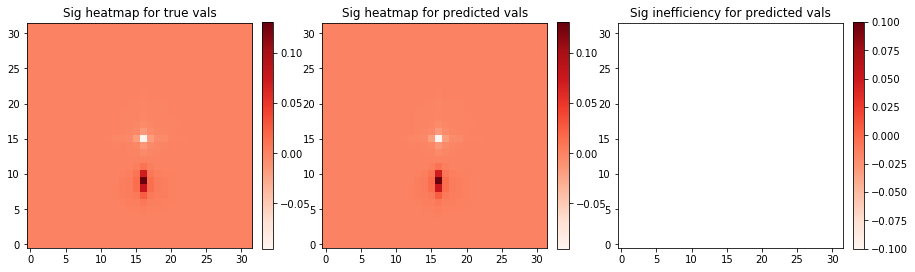

In [14]:
sig_pred_max= np.amax(sig_analysis_pred)         
sig_pred_min = np.amin(sig_analysis_pred)        
sig_ineff_max= np.amax(sig_inefficiency)
sig_ineff_min= np.amin(sig_inefficiency)
sig_true_max= np.amax(sig_analysis_true)
sig_true_min = np.amin(sig_analysis_true)

# Displaying the signal results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im = plt.imshow(sig_analysis_true.reshape(grid,grid), origin = 'low',cmap='Reds', interpolation='nearest', clim=(sig_true_min, sig_true_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Sig heatmap for true vals')
ax.add_subplot(132)
im = plt.imshow(sig_analysis_pred.reshape(grid,grid), origin = 'low', cmap='Reds', interpolation='nearest', clim=(sig_pred_min, sig_pred_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Sig heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(sig_inefficiency.reshape(grid,grid), origin = 'low', cmap='Reds', interpolation='nearest', clim=(sig_ineff_min, sig_ineff_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Sig inefficiency for predicted vals')
plt.show()

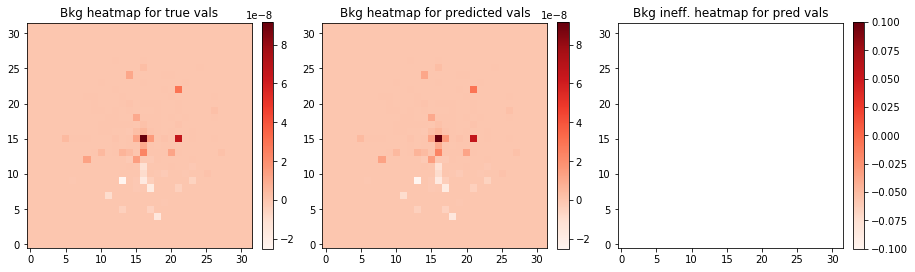

In [15]:
bkg_pred_max= np.amax(bkg_analysis_pred)
bkg_pred_min = np.amin(bkg_analysis_pred)
bkg_ineff_max= np.amax(bkg_inefficiency)
bkg_ineff_min= np.amin(bkg_inefficiency)
bkg_true_max= np.amax(bkg_analysis_true)
bkg_true_min = np.amin(bkg_analysis_true)

# Displaying the background results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im_ = plt.imshow(bkg_analysis_true.reshape(grid,grid), origin = 'low',cmap='Reds', interpolation='nearest', clim=(bkg_true_min, bkg_true_max))
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.title('Bkg heatmap for true vals')
ax.add_subplot(132)
im_ = plt.imshow(bkg_analysis_pred.reshape(grid,grid), origin = 'low',cmap='Reds', interpolation='nearest', clim=(bkg_pred_min, bkg_pred_max))
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.title('Bkg heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(bkg_inefficiency.reshape(grid,grid), origin = 'low', cmap='Reds', interpolation='nearest', clim=(bkg_ineff_min, bkg_ineff_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Bkg ineff. heatmap for pred vals')
plt.show()

## 1D histogram of $\theta$ and z for signal and bkg

Z histogram

In [16]:
plt.hist([sig_zlab[1:], bkg_zlab[1:]] , xbins, 
         color = ['b', 'r'], histtype = 'step', label = ['signal pred', 'background pred'])
# plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'xbins' is not defined

$\theta$ histogram

In [ ]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.hist([z_analysis[0:int(len(predict)/2)], z_analysis[int(len(predict)/2):-1]], bins = 24, histtype = 'step',
         label = ['signal z','bkg z'])
plt.xlabel('relevance of z')
plt.legend()
plt.subplot(122)
plt.hist([theta_analysis[0:int(len(predict)/2)], theta_analysis[int(len(predict)/2):-1]], bins = 24,
         histtype = 'step', label = ['signal theta','bkg theta'])
plt.xlabel('relevance of theta')
plt.legend()
plt.show()